In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import cv2
import shutil
import PIL

from fastai import *
from fastai.vision import *

import json

In [2]:
NUM_SAMPLES_PER_CLASS = 1_000
NUM_VAL = 50 * 340

### Generate data from csvs

In [ ]:
mkdir data/txt

In [ ]:
mkdir data/txt/train

In [2]:
mkdir data/txt/test

In [4]:
def create_train_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.sample(NUM_SAMPLES_PER_CLASS).iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'recognized': row[1].recognized,
            'word': '_'.join(row[1].word.split())
        }
        with open(f'data/txt/train/{example["word"]}_{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)
            
def create_test_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'word': 'unknown'
        }
        with open(f'data/txt/test/{example["word"]}_{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

In [5]:
%time create_test_txts_from_df('data/test_simplified.csv')

CPU times: user 27.6 s, sys: 2.5 s, total: 30.1 s
Wall time: 30.2 s


In [6]:
%time for p in Path('data/train').iterdir(): create_train_txts_from_df(p)

CPU times: user 5min 43s, sys: 19.7 s, total: 6min 2s
Wall time: 5min 58s


###  Create ImageDataBunch using the data block API

In [3]:
sz = 128

In [4]:
%time inp_list = InputList.from_folder('data/txt/train/')

CPU times: user 3.83 s, sys: 792 ms, total: 4.62 s
Wall time: 4.61 s


In [5]:
%time label_list = inp_list.label_from_re('\A([a-zA-Z-_]*)_\d')

CPU times: user 1.09 s, sys: 4 ms, total: 1.1 s
Wall time: 1.09 s


In [6]:
idxs = np.arange(label_list.files.shape[0])
np.random.shuffle(idxs)
val_fns = set(label_list.files[idxs[:NUM_VAL]])

In [7]:
%time split = label_list.split_by_files(val_fns)

CPU times: user 380 ms, sys: 8 ms, total: 388 ms
Wall time: 386 ms


In [8]:
%time _ = split.add_test(InputList.from_folder('data/txt/test/'))

CPU times: user 1.32 s, sys: 320 ms, total: 1.64 s
Wall time: 1.64 s


In [9]:
classes = set(label_list.labels)

# can this change if you train on different data?
# could this be useful for prediction / making a submission?
#
# might want to comment out the creation and saving and only leave loading uncommented on consecutive runs
class2idx = {c: i for i, c in enumerate(classes)}
idx2class = {i: c for c, i in class2idx.items()}
pd.to_pickle(class2idx, 'data/class2idx.pkl')
pd.to_pickle(idx2class, 'data/idx2class.pkl')

class2idx =pd.read_pickle('data/class2idx.pkl')
idx2class = pd.read_pickle('data/idx2class.pkl')

In [10]:
# https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892
BASE_SIZE = 256
def list2drawing(raw_strokes, size=sz, lw=6, time_color=False):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
#     img = cv2.copyMakeBorder(img,4,4,4,4,cv2.BORDER_CONSTANT)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    else:
        return img

In [11]:
def drawing2tensor(drawing):
    rgb = cv2.cvtColor(drawing,cv2.COLOR_GRAY2RGB)
    rgb = rgb.transpose(2,0,1).astype(np.float32)
    return torch.from_numpy(rgb)

In [12]:
class QuickdrawDataset(DatasetBase):
    def __init__(self, x, y):
        super().__init__(x, y, classes=list(class2idx.keys()), c=340, task_type=TaskType.Single, class2idx=class2idx)
    def _get_x(self,i):
        with open(self.x[i]) as f: j = json.load(f)
        drawing = list2drawing(j['drawing'])
        tensor = drawing2tensor(drawing)
        return Image(tensor.div_(255))

In [13]:
%time dss = split.datasets(QuickdrawDataset)

CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 92.9 ms


In [14]:
bs = 640

In [15]:
train_dl = DataLoader(dss.train_ds, batch_size=bs, shuffle=True, num_workers=12)
valid_dl = DataLoader(dss.valid_ds, batch_size=2*bs, shuffle=False, num_workers=12)
test_dl = DataLoader(dss.test_ds, batch_size=2*bs, shuffle=False, num_workers=12)

In [16]:
data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

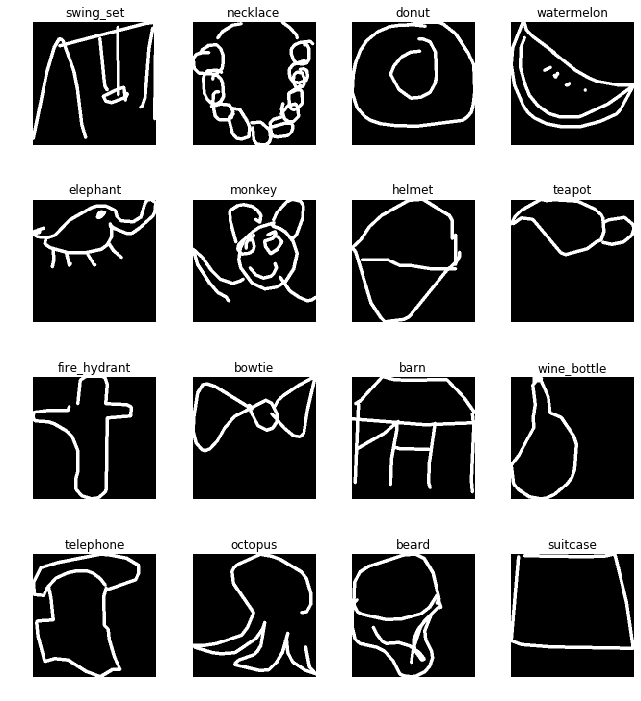

In [17]:
data_bunch.show_batch(rows=4)

In [18]:
# same argument as above - you might want to save this value for later use
batch_stats = data_bunch.batch_stats()
pd.to_pickle(batch_stats, 'data/batch_stats.pkl')
batch_stats = pd.read_pickle('data/batch_stats.pkl')

In [19]:
data_bunch.normalize(batch_stats);

### Train

In [20]:
name = f'res34-{sz}'

In [21]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [22]:
def map3(preds, targs):
    predicted_idxs = preds.sort(descending=True)[1]
    top_3 = predicted_idxs[:, :3]
    res = mapk([[t] for t in targs.cpu().numpy()], top_3.cpu().numpy(), 3)
    return torch.tensor(res)

In [23]:
learn = create_cnn(data_bunch, models.resnet34, metrics=[accuracy, map3])

In [24]:
learn.fit_one_cycle(2)

Total time: 06:00
epoch  train_loss  valid_loss  accuracy  map3    
1      1.922570    1.590134    0.603647  0.692323  (03:01)
2      1.648254    1.431858    0.643176  0.726059  (02:58)



In [25]:
learn.save(f'{name}-stage-1')

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(6, max_lr=6e-4)

Total time: 24:20
epoch  train_loss  valid_loss  accuracy  map3    
1      1.454356    1.326732    0.665471  0.746039  (04:04)
2      1.348246    1.286290    0.670706  0.752647  (04:03)
3      1.148621    1.155290    0.703882  0.779373  (04:03)
4      0.907140    1.041144    0.738235  0.806618  (04:03)
5      0.639917    1.024560    0.743882  0.812265  (04:02)
6      0.455252    1.045359    0.745588  0.812676  (04:03)



In [28]:
learn.save(f'{name}-stage-2')

### Predict

In [29]:
learn.load(f'{name}-stage-2');

In [30]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [31]:
top_3 = np.argsort(preds.numpy())[:, ::-1][:, :3]

In [32]:
labels = []
for i in range(top_3.shape[0]):
    labels.append(' '.join([learn.data.train_ds.classes[idx] for idx in top_3[i]]))

In [33]:
labels[1]

'map pillow van'

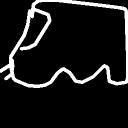

In [34]:
test_dl.dataset[1][0]

In [35]:
key_ids = [path.stem.split('_')[1] for path in learn.data.test_dl.dl.dataset.x]

In [36]:
os.makedirs(f'subs', exist_ok=True)
sub = pd.DataFrame({'key_id': key_ids, 'word': labels})
sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [37]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9672687488031705,pond bush brain
1,9031382648572453,map pillow van
2,9302586427870096,mailbox hammer axe
3,9627281608087084,see_saw yoga cannon
4,9502915523656161,hockey_puck pool bottlecap


In [38]:
# !kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"

100%|██████████████████████████████████████| 1.52M/1.52M [00:16<00:00, 93.9kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge